#Práctica 2. Pablo Rodríguez Fernández


#Preparativos


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [2]:
#Instalamos la ultima version de OpenCV, en la cual el algoritmo SIFT ya es de uso libre
!pip install opencv-contrib-python==4.4.0.44

In [3]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import math
import random

**Funciones auxiliares**

In [4]:
#Funcion para ajustar los valores negativos para facilitar la visualizacion
def pintl(im):
  #Sumar el minimo y multiplicamos por el maximo (ya que el rango numerico es entre [-1,1])
  im=(im+abs(np.min(im))) #Sumamos el valor minimo en valor absoluto
  im=im/np.max(im) #Dividimos todos los valores entre el maximo de la matriz obtenida en el paso anterior
  im = np.array(im*255, dtype = np.uint8) #Escalamos al intervalo [0,255] para que OpenCV muestre correctamente la escala de grises
  cv2_imshow(im)

#Funcion para mostrar juntas imagenes
def pintaMI(vim,grises = True, reescalado = False):
  max_height = 0 # find the max hight of all the images
  total_width = 0 # the total width of the images (horizontal stacking)

  max_height = max(img.shape[0] for img in vim)
  total_width = sum(img.shape[1] for img in vim)

  # create a new array with a size large enough to contain all the images
  if grises:
    final_image = np.zeros((max_height,total_width))
  else:
    final_image = np.zeros((max_height,total_width,3))

  current_x = 0 # keep track of where your current image was last placed in the x coordinate
  for img in vim:
    # add an image to the final array and increment the x coordinate
    final_image[:img.shape[0],current_x:img.shape[1]+current_x] = img
    current_x += img.shape[1]
  if reescalado:
    pintl(final_image)
  else:
    cv2_imshow(final_image)

#Funcion para mostrar imagenes con sus titulos
def visualizar(images,titles,figsize,rows,columns):
  
  fig = plt.figure(figsize=figsize)
  rows=2
  columns=2

  for i in range(len(images)):
    fig.add_subplot(rows,columns,i+1)
    plt.imshow(images[i],cmap='gray')
    plt.axis('off')
    plt.title(titles[i])


#Funciones propias de convolucion y submuestreo
Se incluyen para poder optar al bonus del apartado (f) del ejercicio 1

In [5]:
def submuestrearImagen(img):
  return img[::2,::2]

def recortarPadding(img,padding_filas,padding_columnas):
  rows = img.shape[0]
  columns = img.shape[1]
  return img[padding_filas:(rows-padding_filas),padding_columnas:(columns-padding_columnas)]

def convolucion(img,mask_rows,mask_columns): #El tamaño de la imagen de salida debe ser el mismo que el tamaño de la imagen de entrada

  #Obtencion de datos
  len_mrows = len(mask_rows)
  len_mcolumns = len(mask_columns)
  mask_rows = np.flip(mask_rows)
  mask_columns = np.flip(mask_columns)

  #Tamanho del padding anhadido para convolucionar
  padding_filas = len_mrows//2
  padding_columnas = len_mcolumns//2

  #Anhadimos los bordes. En este casom bordes reflejados
  img = cv.copyMakeBorder(img,padding_filas,padding_filas,padding_columnas,padding_columnas,borderType = cv.BORDER_REFLECT)

  #Creamos las imagenes auxiliares utilizadas en la convolucion 
  img_convolucionada_filas = np.zeros(shape=img.shape)
  img_convolucionada = np.zeros(shape=img.shape)

  #Obtenemos numero de filas y de columnas de la imagen con bordes
  rows = img_convolucionada.shape[0]
  columns = img_convolucionada.shape[1]

  #Convolucion por filas (mask_rows)
  mega_mask_rows = np.tile(mask_rows,rows).reshape((rows,len_mrows))
  for j in range(columns-len_mrows+1):
    img_part = img[:,j:j+len_mrows]
    img_convolucionada_filas[:,j+padding_filas] = np.sum(mega_mask_rows*img_part,axis=1)

  #Transponemos la imagen para aplicar la convolucion por columnas de la misma manera que se aplica por filas
  img_convolucionada_filas_t = img_convolucionada_filas.transpose()

  #Convolucion por columnas (mask_columns)
  mega_mask_columns = np.tile(mask_columns,columns).reshape((columns,len_mcolumns))
  for i in range(rows-len_mcolumns+1): 
    img_part = img_convolucionada_filas_t[:,i:i+len_mcolumns]
    img_convolucionada[i+padding_columnas,:] = np.sum(mega_mask_columns*img_part,axis=1)

  #Eliminamos el padding para obtener una imagen del mismo tamanho que la de entrada
  img_convolucionada = recortarPadding(img_convolucionada,padding_filas,padding_columnas)

  return img_convolucionada

#Funcion propia mascaras gaussianas

In [6]:
def mascarasGaussianas(sigma=-1,longitud=-1):

  #Calculo de parametros
  if sigma!=-1: #Nos proporcionan el sigma
    longitud = 2*np.ceil(2.5*sigma)+1

  else: #Nos proporcionan el tamanho de la mascara 
    sigma = (longitud-1)/5 # 5==2*2.5

  #Creacion de la estructura de la mascara
  extension_mascara = longitud//2
  valores=np.arange(-extension_mascara,extension_mascara+1)
  
  #Funciones evaluadoras
  gaussiana = lambda valor,sigma : np.exp(-(valor**2)/(2*sigma**2))
  primeraDerivada = lambda valor,sigma : sigma*(-valor/sigma**2)*np.exp(-valor**2/(2*sigma**2))
  segundaDerivada = lambda valor,sigma : (sigma**2)*((-1/sigma**2)+(valor**2/sigma**4))*np.exp(-valor**2/(2*sigma**2))
  
  #Calculo Mascara Gaussiana
  msn_gaussiana  = np.array([gaussiana(i,sigma) for i in valores]) #Mascara sin normalizar
  mascara_gaussiana = msn_gaussiana / np.sum(msn_gaussiana)

  #Calculo Mascara Primera derivada
  mascara_1derivada  = np.array([primeraDerivada(i,sigma) for i in valores]) 

  #Calculo Mascara Segunda derivada
  mascara_2derivada  = np.array([segundaDerivada(i,sigma) for i in valores]) 

  return mascara_gaussiana,mascara_1derivada,mascara_2derivada



#Ejercicio 1: Extracción de regiones relevantes en un espacio de escalas.

**Este punto se centra en detectar KeyPoints sobre cada una de las imágenes de Yosemite.rar (usar versiones en rango de gris) y dibujarlos sobre las imágenes haciendo uso de la función drawKeyPoints(). Para ello, se ha de construir un Espacio de Escalas (pirámide) de Lowe con cuatro octavas en total y tres escalas dentro de cada octava. Suponer que la imagen original está afectada por un alisamiento debido a la captura de $\sigma=0.8$ y queremos introducir una primera octava de índice-0 de manera que la imagen semilla ( $v_0^1$) en el espacio de escalas tenga un $\sigma=1.6.$**

**a)¿Qué operaciones sobre la imagen original nos permite fijar un valor de 𝜎 = 1.6 en la imagen semilla?**

Imagen original vs Imagen semilla


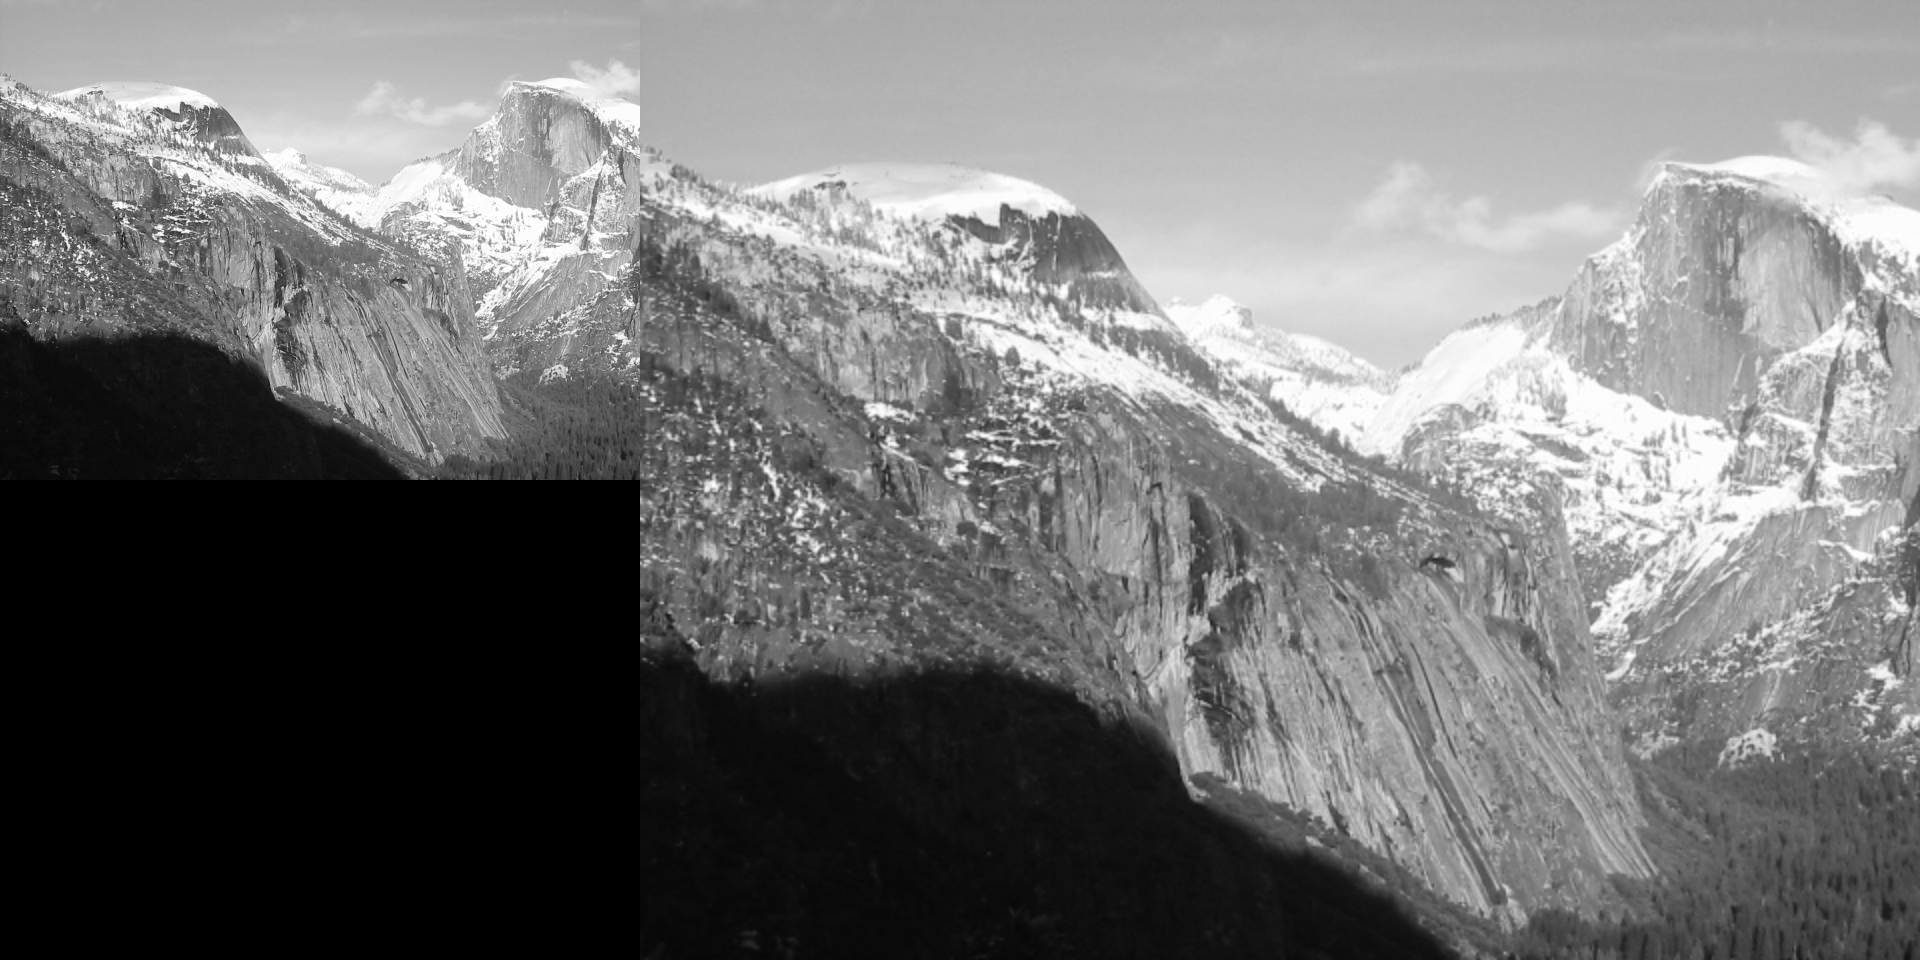

In [7]:
def seedImage(img):
  dimension = (img.shape[1]*2,img.shape[0]*2)
  seed_img = cv.resize(img,dimension,interpolation = cv.INTER_LINEAR)
  return seed_img

img = cv.imread('images/Yosemite1.jpg',0).astype(np.float64)
seed_img = seedImage(img)
print("Imagen original vs Imagen semilla")
pintaMI([img,seed_img])

El algoritmo SIFT supone que la imagen inicial tiene un alisamiento debido a la cámara de $\sigma=0.5$. Para obtener $\sigma=1.6$, se debe alisar la imagen hasta un $\sigma_{ini}=0.8$ e interporlarla bilinealmente con un paso de $\delta_0=0.5$ (lo que significa doblar su tamaño), ya que de esta manera, $\sigma_0=\frac{\sigma_{ini}}{\delta_0}$.

Sin embargo, en este caso, se asume que inicialmente se tiene un $\sigma=0.8$ debido a la captura. Por tanto, para llegar al $\sigma_0=1.6$, solamente debemos realizar el paso de interpolación, no siendo necesario el alisamiento previo.

**b) Implementar una función que calcule las escalas de cualquier octava de la forma más eficiente posible. Es decir, reusable para cualquier escala.**

In [8]:
#Argumentos: 
#   sigma0 -> Sigma inicial
#   nscales -> Numero de escalas de la octava
#Retorna:
#   sigmas -> Sigmas necesarios para calcular las octavas
def calculateSigmas(sigma0,nscales):
  sigmas = []
  for s in range(1,nscales+3):
    sigma_s = sigma0*math.sqrt(2**(2*s/nscales)-2**(2*(s-1)/nscales))
    sigmas.append(sigma_s)
  return sigmas


#Argumentos: 
#   img -> Imagen semilla (no la original)
#   sigmas -> Sigmas utilizados en la piramide (su numero determina el numero de escalas)
#Retorna:
#   octave -> Matriz cubica con la octava asociada a la imagen semilla: [x,y,escala]
#Comentarios: El numero de escalas de la octava se infiere del numero de sigmas
#             (cada sigma se corresponde con una escala)
def calculateOctave(img,sigmas):
  octave = []
  nscales = len(sigmas)

  img_scale = img
  octave = np.zeros(shape=(img_scale.shape[0],img_scale.shape[1],nscales+1),dtype=np.float64)
  octave[:,:,0]=img_scale

  for s in range(0,nscales): #La primera imagen solamente se submuestrea, no se alisa!
    gaussian_mask = mascarasGaussianas(sigma=sigmas[s])[0]
    img_scale = convolucion(img_scale,gaussian_mask,gaussian_mask)
    octave[:,:,s+1] = img_scale

  return octave


En este apartado se implementa dos funciones: *calculateSigmas()* y *calculateOctave()*.

La función *calculateSigmas()* recibe como parámetros un $\sigma$ inicial y el número de escalas que va a tener la octava, y devuelve los sigmas de alisamiento asociados a cada nivel de la octava. Por defecto, el paper de Lowe fija $\sigma_0 = 1.6$, que es el valor que se le pasa a la función para calcular el resto de sigmas a partir de él, empleando la expresión
$$\sigma_s = \sigma_0 \times \sqrt{2^{\frac{2s}{n_s}}-2^{\frac{2(s-1)}{n_s}}}, s=1,...,ns+2 $$ siendo $ns$ el número de escalas dentro de la octava

Por otro lado, la función *calculateOctave()* es la que realiza el cálculo de la octava de una imagen base, recibiendo como parámetros dicha imagen y un listado de sigmas. La razón de que uno de los argumentos sea el listado de sigmas es que este no es necesario recalcularlo en cada octava, ya que el valor de sigma solo depende de la escala y del número de escalas de la octava, no de la octava.

Respecto al cálculo de la octava, en primer lugar se crea la estructura que la contendrá, que es un tensor en el cual las dos primeras componentes hacen referencia a las coordenadas del píxel de una imagen y la última a la escala en la cual se encuentra dicho píxel. Tras esto, se entra en el bucle que crea las distintas escalas que componen la octava.

Para crear cada escala,primero se obtiene la máscara gaussiana cuyo sigma se corresponde con el sigma asociado a la escala que se está calculando. Tras ello, se convoluciona la imagen con dicha máscara, a fin de alisarla. Finalmente, se añade la imagen convolucionada (la escala) a la octava.


**c)Usar la función implementada en (b) para calcular las escalas de todas las octavas (0-3). Mostrar las imágenes calculadas agrupadas por octava (mostrar solo las escalas 1,2 y 3 en cada octava).**

Octava  0


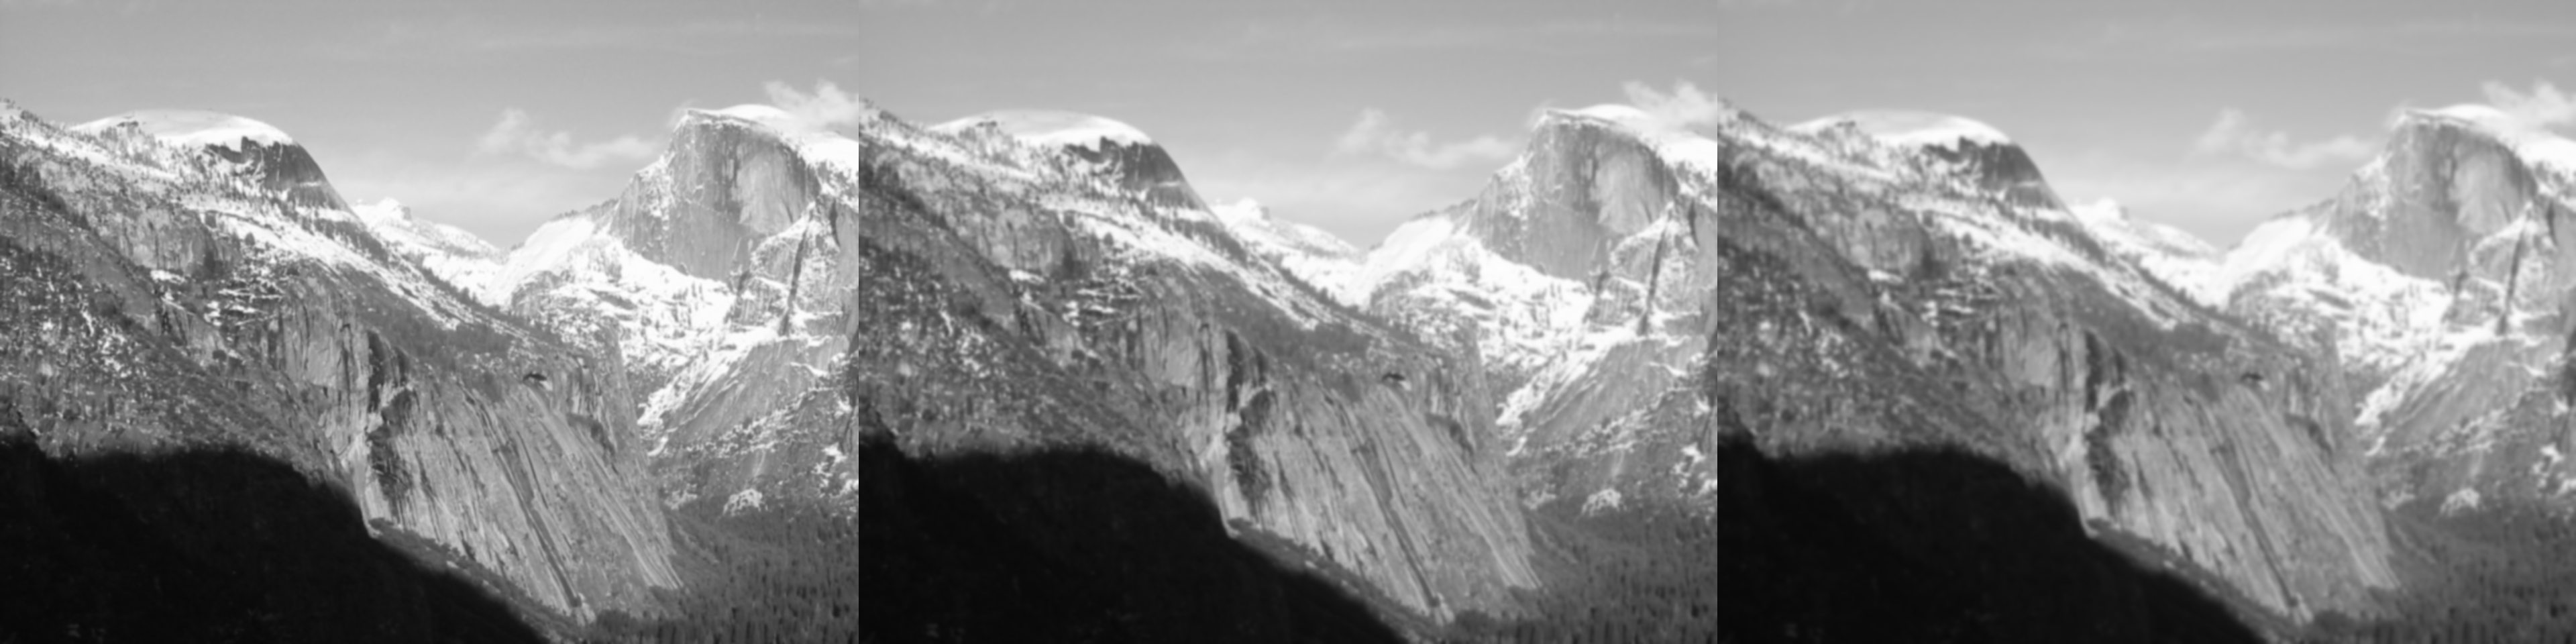



Octava  1


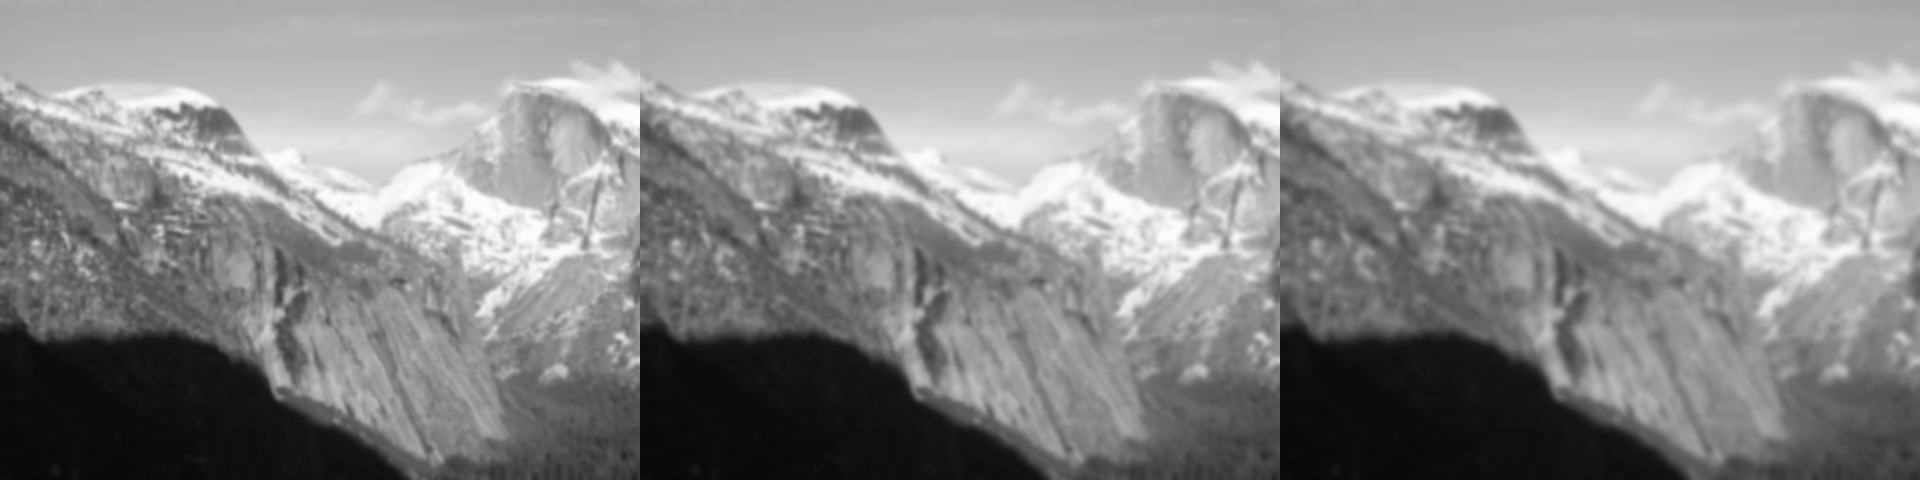



Octava  2


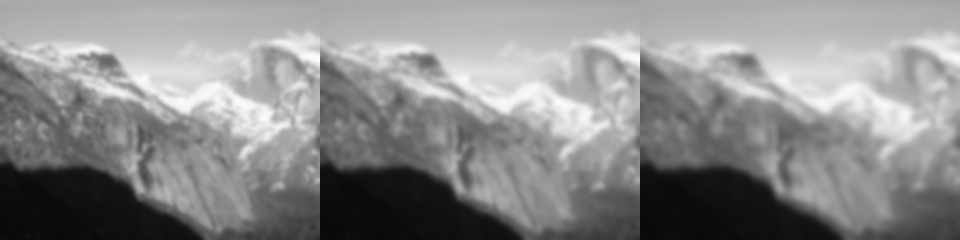



Octava  3


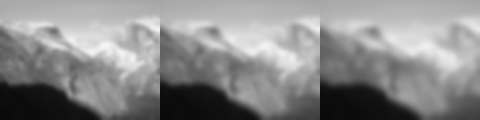

In [9]:
#Argumentos
#   img-> Imagen semilla
#   nscales -> Numero de escalas de cada octava
#   noctaves -> Numero de octavas
#Retorna
#   octaves -> Octavas calculadas
def obtainOctaves(img,nscales=3,noctaves=4): 
  octaves=[]
  baseImage= img
  sigmas = calculateSigmas(1.6,nscales) #sigma0 = 1.6
  for o in range(noctaves): #Para incluir la octava 0
    actual_octave=calculateOctave(baseImage,sigmas)
    octaves.append(actual_octave)
    baseImage = actual_octave[:,:,3] #Cada octava tiene 3 imagenes adicionales (y al inicio y 2 al final)
    baseImage = submuestrearImagen(baseImage) #Submuestreamos la imagen inicial
  return octaves

img = cv.imread('images/Yosemite1.jpg',0).astype(np.float64)

nscales=3
noctaves=4

seed_img = seedImage(img)
octaves = obtainOctaves(seed_img,nscales,noctaves)
lista = []

for i in range(noctaves):
  print("Octava ",i)
  for j in range(1,4):#Mostramos solo las escalas 1,2 y 3
    lista.append(octaves[i][:,:,j])
  pintaMI(lista)
  lista.clear()
  print("\n")

En este ejercicio se pide calcular las octavas 0-3 de una imagen utilizando la función de creada en el apartado anterior para calcular una octava.

Dicha funcionalidad la implementa la función *obtainOctaves()*, la cual, en primer lugar, calcula los $\sigma$ necesarios para calcular las escalas de las octavas. Por como se implementó en el apartado anterior, solo es necesario llamar a esta función al inicio.

Tras esto, se entra en un bucle el cual, en primer lugar, invoca a la función *calculateOctave()* (la del apartado anterior) para calcular la octava actual. Luego,se extrae la cuarta imagen de la octava, que será la base de la siguiente octava, y la submuestrea a la mitad. Más en detalle:

*   Se toma la cuarta imagen de la octava como base para la siguiente debido a que, si bien decimos que cada octava tiene 3 escalas, en realidad se están calculando 6. Para poder calcular de manera correcta el espacio de escalas Laplaciano, se añade una escala inicial (idéntica a la última "real" de la octava anterior pero submuestreada) y dos al final, de ahí que la última escala "real" sea la cuarta en este caso.

*   El submuestreo de la imagen se realiza al final del bucle y no al comienzo para que no se realice submuestreo en la octava 0, ya que si se hiciese, se estaría "destruyendo" la imagen semilla del espacio de octavas (ya que inicialmente se interpola al doble para lograr un $\sigma_0=1.6$, y si se submuestrease, se volvería al $\sigma=0.8$ base con el que se sacó la fotografía).

En los resultados se muestran solo las escalas 1,2 y 3 de cada octava, ya que el resto son las "añadidas" que se utilizarán posteriormente. Se puede ver como, en cada imagen, el alisamiento es mayor; y en cada octava, el tamaño de las imágenes se reduce a la mitad (debido al submuestro).



**d)Calcular el espacio de escalas Laplaciano a partir de la pirámide e identificar los 100 extremos locales con mayor respuesta, presentes en la misma. Extraer en un vector $(x,y,\sigma)$ para cada uno de ellos en los ejes de la imagen original.**

In [10]:
#Argumentos:
#   -octaves: Piramide de octavas asociadas a una imagen semilla
#Retorna:
#   -scaleSpace: Espacio de escalas Laplaciano asociado a la piramide de octavas
def laplacianScaleSpace(octaves):
  noctaves = len(octaves)
  nscales = len(octaves[0][0,0,:])

  scaleSpace=[]

  for o in range(noctaves):
    levelScaleSpace = np.zeros(shape=(octaves[o][:,:,0].shape[0],octaves[o][:,:,0].shape[1],nscales),dtype=np.float64)
    for s in range(nscales-1):
      levelScaleSpace[:,:,s]=(octaves[o][:,:,s+1]-octaves[o][:,:,s])
    scaleSpace.append(levelScaleSpace)

  return scaleSpace

def localExtremes(scaleSpace,nmax):
  #Ver "AnatomySIFT", pagina 6--------------------------------
  delta_o = lambda o: 2**(o-1) # delta_min = 0.5
  sigma_o_s = lambda s,o: delta_o(o)*1.6*2**(s/3) #delta_min = 0.5 , sigma0=1.6, nscales=3
  #-----------------------------------------------------------
  noctaves = len(scaleSpace)
  nscales = len(scaleSpace[0])

  extremos = [] #Listado resultado

  valoresScaleSpace = [] #Array auxiliar
  ubicaciones = [] #Ubicacion en el espacio de escalas Laplaciano de un punto

  #Las escalas comparadas en cada octava son las 0-1-2 [0:3],1-2-3 [1:4] y 2-3-4 [2:5]
  for o in range(noctaves):#Seleccionamos una octava
    #En cada octava, analizamos 3 conjuntos de 3 escalas
    octava = scaleSpace[o][:]
    for s in range(0,3):
      cubo= octava[:,:,s:s+3]
      width, height, channels = cubo[:,:,:].shape
      #Recorremos cada conjunto, comparando un pixel de la capa central con sus 26 vecinos en esa capa y las externas
      for i in range(1,width-1): #Eliminamos la ultima fila y la ultima columna porque ahi no se puede comparar con 26 vecinos!
        for j in range(1,height-1):
          vector = np.copy(cubo[i-1:i+2,j-1:j+2,0:3]).flatten()   
          puntoCentral = vector[13]
          vector = np.subtract(vector,puntoCentral)    
          valoresScaleSpace.append(vector)
          ubicaciones.append([i,j,s,o,cubo[i,j,1]])

  #Convertimos los puntos en una matriz de 27 columnas
  listado = np.copy(valoresScaleSpace).flatten()
  listado = np.reshape(listado,(len(valoresScaleSpace),27))
  
  #Binarizamos la matriz y sumamos por filas
  binarizacion = np.where(listado>0,1,0)
  sumas = np.sum(binarizacion,axis=1)

  #Comprobamos si un elemento es un extremo local
  for i in range(sumas.shape[0]):
    if sumas[i]==26 or sumas[i]==0:
      iE = ubicaciones[i][0]
      jE = ubicaciones[i][1]
      sE = ubicaciones[i][2]
      oE = ubicaciones[i][3]
      valorE = ubicaciones[i][4]
      delta = delta_o(oE)
      extremos.append([delta*iE,delta*jE,sigma_o_s(sE,oE),np.absolute(valorE)])
  
  #Una vez tenemos el listado, la ordenamos de mayor a menor y nos quedamos con los 100 mayores
  extremos = np.array(extremos)
  extremos = extremos[np.argsort(-extremos[:,3])[:nmax]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremos = np.delete(extremos,3,1) #Eliminamos la ultima componente de todos los puntos ("la ultima columna de la matriz")
  
  return extremos



En este ejercicio se implementan dos funciones: una para calcular el espacio de escalas Laplaciano asociado a un conjunto de octavas, *laplacianScaleSpace()*; y otra para obtener los máximos extremos locales de dicho espacio de escalas, *localExtremes()*. Trataremos en primer lugar la construcción del espacio de escalas Laplaciano.

La construcción de este espacio de escalas se realiza por aproximación mediante *Diferencias de Gaussianas* (recordemos que cada octava se compone de una imagen base alisada repetidamente con máscaras gaussianas).Para calcular estas diferencias se debe, dentro de cada octava, restar el valor del nivel $s$ al nivel $s+1$. Aquí está la razón de porqué incluir más escalas de las "reales" en cada octava. Si solamente tuviésemos las 3 escalas, solo nos saldrían 2 escalas dentro de cada octava del espacio de escalas Laplaciano.




Pasemos ahora al cálculo de los extremos locales. Para encontrar los extremos, el artículo de Lowe propone formar un *cubo* de 3x3 píxeles, donde cada "capa" del cubo se encuentra en una escala diferente (siempre dentro de una misma octava). Dicho cubo va recorriendo todas las posiciones dentro de la octava y realiza la siguiente comparación: si su píxel central es el máximo o mínimo del cubo en dicho momento (es decir, si un píxel es el máximo o mínimo de sus 26 vecinos), entonces se etiqueta como extremo local. Este proceso se debe realizar en todas las octavas.

Este proceso, el cual no es difícil de programar directamente, es muy ineficiente, ya que implica una gran cantidad de movimientos, comparaciones,etc. Esta fue mi aproximación inicial al problema, pero tardaba en procesar cada imagen unos 2 minutos y 20 segundos. En clase de prácticas se comentaron varias posibles maneras de acelerar estos cálculos, e implementé una de ellas, la cual consigue rebajar el tiempo a aproximadamente la mitad por cada imagen.

Dicha mejora consiste en, una vez tenemos los puntos que conforman un cubo, lo convertimos en un vector, al que le restamos el valor del elemento inicial (que se corresponde con el píxel del medio del cubo, que recordemos es el candidato a extremo). Este vector se almacena, y se repite este proceso para todos los cubos posibles. En este momento, almacenamos también en un array las coordenadas, la escala, la octava y el valor del píxel central, ya que serán valores necesarios más adelante.

Una vez tenemos todos los vectores almacenados, le damos de matriz, que tendrá 27 columnas y tantas filas como elementos haya en el listado de vectores. Dicha matriz la binarizamos : si un valor es negativo o 0, se pone 0 en su posición; y si es positivo, 1. Tras esto, sumamos por filas y comparamos el valor: si la suma es 26, el punto será un máximo, mientras que si la suma es 0, será un mínimo. En todo caso, si es 0 o 26, el punto del espacio de escalas laplaciano asociado a dicha fila (que podemos recuperar gracias a los valores que guardamos al principio) es un extremo local. En dicho caso, solo resta hallar las coordenadas de dicho extremo en la imagen original, multiplicando cada coordenada $(x,y)$ por un valor $\delta$, y hallando el sigma real correspondiente al alisamiento acumulado en la escala y octava en la que se detectó el extremos.Las fórmulas de $\delta$ y  de $\sigma$, extraídas del documento *AnatomySIFT.pdf*, son los siguientes:    

$$\delta = 2^{o-1}$$
$$\sigma = \delta * \sigma_0*2^{\frac{s}{ns}}$$
siendo $o$ la octava, $s$ la escala y $ns$ el número de escalas en cada octava.  

También se almacena el valor absoluto del extremo, ya que se pide devolver los 100 mayores, y de esta manera podemos ordenarlos, que es lo que realiza en las últimas líneas de la función.

**e)Mostrar la imagen con los extremos locales extraídos usando para ello un círculo de radio 6x sobre la escala de detección $\sigma$.**


SIFT aplicado a Yosemite1


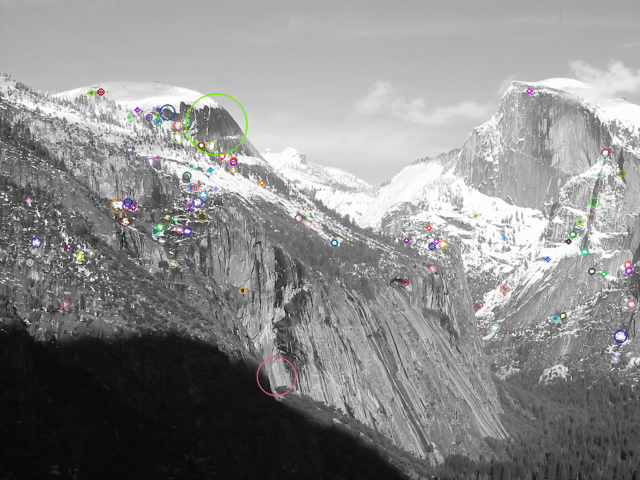


SIFT aplicado a Yosemite2


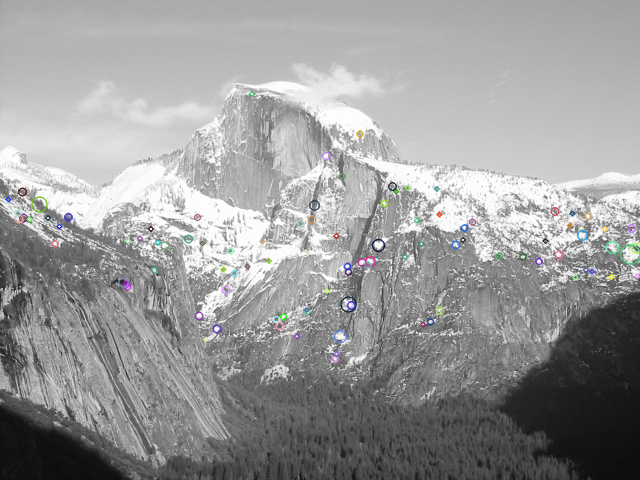

In [11]:
#Argumentos:
#   -img: Imagen original
#Retorna:
#   -finalImage: imagen copia de la original con los extremos representados
def SIFT(img,nscales=3,noctaves=4):
  #Obtenemos la imagen semilla
  seed_img = seedImage(img)
  #Calculamos la octavas
  octaves = obtainOctaves(seed_img,nscales,noctaves)
  #Calculamos el espacio de escalas laplaciano
  scaleSpace = laplacianScaleSpace(octaves)
  #Obtenemos los extremos locales
  extremosLocales= localExtremes(scaleSpace,100)
  keypoints = []
  #Convertimos los extremos en KeyPoints de openCV
  for extremo in extremosLocales:
    keypoints.append(cv.KeyPoint(extremo[1],extremo[0],6*extremo[2]))
  #Cambiamos la imagen de formato (admitida por la funcion de openCV)
  img = np.uint8(img)
  #Dibujamos sobre la imagen los KeyPoints calculados
  finalImage = cv.drawKeypoints(img, keypoints, None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  return finalImage


#Leemos las imagenes
imgYosemite1 = cv.imread('images/Yosemite1.jpg',0).astype(np.float64)
imgYosemite2 = cv.imread('images/Yosemite2.jpg',0).astype(np.float64)

#Mostramos el resultado
print("\nSIFT aplicado a Yosemite1")
finalYosemite1 = SIFT(imgYosemite1)
cv2_imshow(finalYosemite1)

print("\nSIFT aplicado a Yosemite2")
finalYosemite2 = SIFT(imgYosemite2)
cv2_imshow(finalYosemite2)

En este apartado se utilizan las funciones elaboradas en los apartados anteriores para implementar el algoritmo SIFT para la detección de características (parcialmente, ya que no incluye refinamiento de extremos u orientación) , propuesto por David Lowe.

La función *SIFT()* implementa parcialmente dicho algoritmo, cuyas etapas se pueden agrupar en las siguientes:

*   Obtención de la imagen semilla, utilizando para ello la función *seedImage()*.

*   Cálculo la pirámide de Lowe, la cual se compone de 4 octavas calculadas a partir de la imagen semilla (utilizando para ello la función *obtainOctaves()*) que permiten calcular el espacio de escalas Laplaciano utilizando para ello la función *laplacianScaleSpace())*.

*   Sobre dicho espacio de escalas Laplaciano, se buscan mayores máximos y mínimos, empleando el mecanismo explicado en el apartado anterior (utilizando para ello la función *localExtremes()*)

Una vez se tienen los extremos, se convierten al tipo de dato de OpenCV *KeyPoint*, a fin de representarlos sobre la imagen inicial utilizando la función *drawKeypoints()*. Utilizando las flags adecuadas, dicha función dibuja un círculo alrededor del píxel cuyo tamaño es proporcional al $\sigma$ asociado a su detección por el algoritmo.

Se muestran a modo ejemplo los 100 mayores extremos (en valor absoluto) obtenidos en las imágenes *Yosemite1* y *Yosemite2*. En ambas imágenes, se puede ver como la mayoría de los extremos se encuentros en las primeras octavas y escalas de la pirámide de Lowe (a menor radio del círculo, menor escala). Cabe destacar en *Yosemite1* dos extremos a mayores escalas, los cuales parecen ser estimaciones erróneas porque no coinciden exactamente con ningún cambio en el punto en el que están centradas. Sin embargo, el resto de extremos detectados en ambas imágenes si parecen estar en ubicaciones correctas (a nivel visual), estando agrupados en los bordes entre las zonas con nieve y sin ella, o en zonas que parecen barrancos y grandes pendientes en la falda de la montaña.








**g) Bonus.- Pintar los mayores extremos detectados por SIFTde acuerdo a la siguiente distribución por octavas: octava 1 (50% del total), octava 2 (25% del total), octava 3 (15% del total) y octava 4 (10% del total)**


SIFT aplicado a Yosemite1


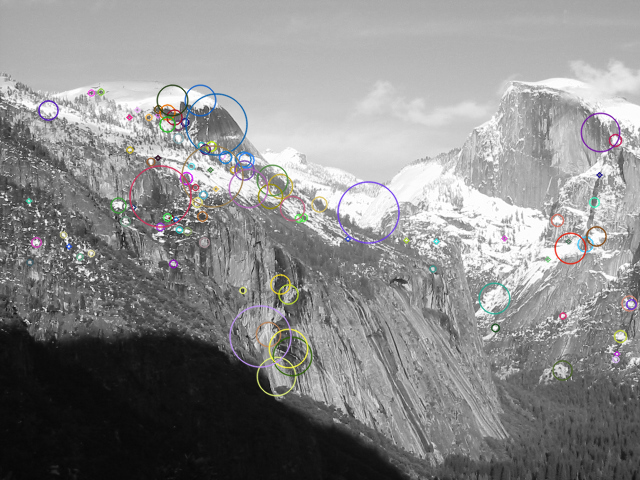


SIFT aplicado a Yosemite2


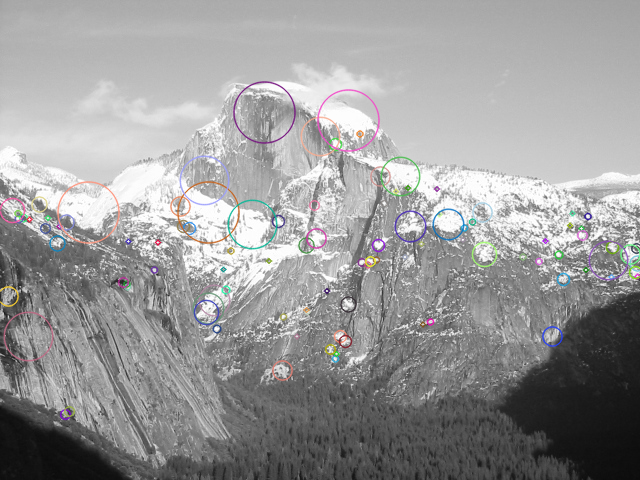

In [12]:
#Argumentos:
#   -scaleSpace: Espacio de escalas laplaciano
#   -nmax: Numero de maximos locales con mayor respuesta a devolver
#Retorna:
#   -: Lista con los pixeles (x,y,sigma)  de mayor respuesta según la distribución pedida
def localExtremesBonus(scaleSpace,nmax):
  #Ver "AnatomySIFT", pagina 6--------------------------------
  delta_o = lambda o: 2**(o-1) # delta_min = 0.5
  sigma_o_s = lambda s,o: delta_o(o)*1.6*2**(s/3) #delta_min = 0.5 , sigma0=1.6, nscales=3
  #-----------------------------------------------------------
  noctaves = len(scaleSpace)
  nscales = len(scaleSpace[0])

  extremos = [] #Listado resultado
  valoresScaleSpace = []
  ubicaciones = []

  #Las escalas comparadas en cada octava son las 0-1-2 [0:3],1-2-3 [1:4] y 2-3-4 [2:5]
  for o in range(noctaves):#Seleccionamos una octava
    #En cada octava, analizamos 3 conjuntos de 3 escalas
    octava = scaleSpace[o][:]
    for s in range(0,3):
      cubo= octava[:,:,s:s+3]
      width, height, channels = cubo[:,:,:].shape
      #Recorremos cada conjunto, comparando un pixel de la capa central con sus 26 vecinos en esa capa y las externas
      for i in range(1,width-1): #Eliminamos la ultima fila y la ultima columna porque ahi no se puede comparar con 26 vecinos!
        for j in range(1,height-1):
          vector = np.copy(cubo[i-1:i+2,j-1:j+2,0:3]).flatten()   
          puntoCentral = vector[13]
          vector = np.subtract(vector,puntoCentral)    
          valoresScaleSpace.append(vector)
          ubicaciones.append([i,j,s,o,cubo[i,j,1]])

  #Convertimos los puntos en una matriz de 27 columnas
  listado = np.copy(valoresScaleSpace).flatten()
  listado = np.reshape(listado,(len(valoresScaleSpace),27))
  
  #Binarizamos la matriz y sumamos por filas
  binarizacion = np.where(listado>0,1,0)
  sumas = np.sum(binarizacion,axis=1)
  
  #Comprobamos si un elemento es un extremo local
  for i in range(sumas.shape[0]):
    if sumas[i]==26 or sumas[i]==0:
      iE = ubicaciones[i][0]
      jE = ubicaciones[i][1]
      sE = ubicaciones[i][2]
      oE = ubicaciones[i][3]
      valorE = ubicaciones[i][4]
      delta = delta_o(oE)
      extremos.append([delta*iE,delta*jE,sigma_o_s(sE,oE),np.absolute(valorE),oE])
  
  extremos = np.array(extremos)
  #Filtramos los extremos en funcion de la octava en la que se encontraron
  filter1 = extremos[:,4] == 0
  filter2 = extremos[:,4] == 1
  filter3 = extremos[:,4] == 2
  filter4 = extremos[:,4] == 3
  extremosOctava1 = extremos[filter1]
  extremosOctava2 = extremos[filter2]
  extremosOctava3 = extremos[filter3]
  extremosOctava4 = extremos[filter4]
  
  #Ordenamos los extremos y extraemos solamente x de ellos, siendo x la distribucion del enunciado
  extremosOctava1 = extremosOctava1[np.argsort(-extremosOctava1[:,3])[:50]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremosOctava2 = extremosOctava2[np.argsort(-extremosOctava2[:,3])[:25]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremosOctava3 = extremosOctava3[np.argsort(-extremosOctava3[:,3])[:15]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremosOctava4 = extremosOctava4[np.argsort(-extremosOctava4[:,3])[:10]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  
  #Concatenamos los extremos de cada octava y eliminamos las componentes auxiliares
  extremos = np.concatenate((extremosOctava1,extremosOctava2,extremosOctava3,extremosOctava4))
  extremos = np.delete(extremos,(3,4),1) 

  return extremos

#Argumentos:
#   -img: Imagen original
#Retorna:
#   -finalImage: imagen copia de la original con los extremos representados
def SIFTg(img,nscales=3,noctaves=4):
  #Obtenemos la imagen semilla
  seed_img = seedImage(img)
  #Calculamos la octavas
  octaves = obtainOctaves(seed_img,nscales,noctaves)
  #Calculamos el espacio de escalas laplaciano
  scaleSpace = laplacianScaleSpace(octaves)
  #Obtenemos los extremos locales
  extremosLocales= localExtremesBonus(scaleSpace,100)
  keypoints = []
  #Convertimos los extremos en KeyPoints de openCV
  for extremo in extremosLocales:
    keypoints.append(cv.KeyPoint(extremo[1],extremo[0],6*extremo[2]))
  #Cambiamos la imagen de formato (admitida por la funcion de openCV)
  img = np.uint8(img)
  #Dibujamos sobre la imagen los KeyPoints calculados
  finalImage = cv.drawKeypoints(img, keypoints, None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  return finalImage


#Leemos las imagenes
imgYosemite1 = cv.imread('images/Yosemite1.jpg',0).astype(np.float64)
imgYosemite2 = cv.imread('images/Yosemite2.jpg',0).astype(np.float64)

#Mostramos el resultado
print("\nSIFT aplicado a Yosemite1")
finalYosemite1 = SIFTg(imgYosemite1)
cv2_imshow(finalYosemite1)

print("\nSIFT aplicado a Yosemite2")
finalYosemite2 = SIFTg(imgYosemite2)
cv2_imshow(finalYosemite2)




En este apartado, variación del (e), se pide pintar en la imagen los extremos en función de la octava en la que se encontraron: (decidí ponerlo aparte para poder comparar los 100 extremos "originales" con los 100 extremos filtrándolos por octavas).

En la implementación, la única diferencia es que es necesario almacenar la octava asociada a un píxel (en la variable *ubicaciones*), y que el listado de extremos debe filtrarse para seleccionar aquellos que se adapten a la distribución del enunciado.

Si se comparan las imágenes anteriores con las del apartado anterior, se puede ver cómo las zonas en las que se ubican los extremos han cambiado. En la primera imagen, *Yosemite1*, se siguen detectando muchos extremos en los cambios de zona de nieve a zonas sin nieve. Sin embargo, ahora aparece un mayor número en la falda de la montaña, donde los cambios se deben a modificaciones del relieve de la misma (no son diferencias tan intensas como las que se dan entre el blanco de la nieve y el gris del resto).

Respecto a *Yosemite2*,sucede algo similar, aunque en este caso sí que parecen detectarse todavía a mayores escalas sobre todo cambios de nieve-no nieve.


#Ejercicio 2

**Con cada dos de las imágenes de Yosemite con solapamiento detectar y extraer los descriptoresSIFTde OpenCV, usando para ello la función cv2. detectAndCompute() . Establecer los puntos encorrespondencias existentes entre las dos imágenes usando el objeto BFMatcher de OpenCV y los criterios de correspondencias “BruteForce+crossCheck y “Lowe-Average-2NN”. Mostrar ambas imágenes en un mismo canvas y pintar líneas de diferentes colores entre las coordenadas de los puntos en correspondencias. Mostrar en cada caso un máximo de 100 elegidas aleatoriamente.**

In [13]:
#Leemos la imagen
img1 = cv.imread('images/Yosemite1.jpg',0)
img2 = cv.imread('images/Yosemite2.jpg',0)

#######Calculo de keypoints y descriptores
sift = cv.SIFT_create()
keypoints1, descriptor1 = sift.detectAndCompute(img1,None)   #des es el descriptor
keypoints2, descriptor2 = sift.detectAndCompute(img2,None)   #des es el descriptor


# Match descriptors: BruteForce+crossCheck
bf = cv.BFMatcher(crossCheck = True)
matchesBrute = bf.match(descriptor1,descriptor2)

# Match descriptors: Lowe-Average-2NN
bf = cv.BFMatcher(crossCheck=False)
matches2NN = bf.knnMatch(descriptor1, descriptor2, k=2)
# Aplicamos el ratio de Lowe: 
matches2NN = [[m] for m,z in matches2NN if m.distance < 0.7 * z.distance]

# Escogemos 100 correspondencias aleatorias
matchesBrute = random.sample(matchesBrute,100)
matches2NN = random.sample(matches2NN,100)

# Dibujamos los 100 primeros matches.
imageBrute = cv.drawMatches(img1,keypoints1,img2,keypoints2,matchesBrute,None, flags=2)
image2NN = cv.drawMatchesKnn(img1,keypoints1,img2,keypoints2,matches2NN,None, flags=2)

#Resultados
print("Emparejamientos/matching usando SIFT y Bruteforce+CrossCheck")
cv2_imshow(imageBrute)
print("\nEmparejamientos/matching usando SIFT y Lowe-Average-2NN")
cv2_imshow(image2NN)

Output hidden; open in https://colab.research.google.com to view.

En este ejercicio se pide extraer los descriptores SIFT de dos imágenes con solapamiento y estudiar los matches que se dan entre ellas utilizando dos criterios distintos: *BruteForce+crossCheck* y *Lowe-Average-2NN*. Expliquemos brevemente dichos criterios.

El criterio **BruteForce+crossCheck** toma un descriptor del primer conjunto y lo empareja con todos los descriptores del segundo conjunto, escogiendo aquel con el que tenga menor distancia (euclideana por defecto, la cuál es la más apropiada para SIFT, de ahí que se deje ese valor). Ahora bien, esa sería solamente la parte de **BruteForce**. Al activar la flag **crossCheck**, solo se elige una pareja si es la mejor en ambos sentidos. Es decir, si A es un descriptor de la imagen I1 y B es un descriptor de la imagen I2, la pareja (A,B) es un match solamente si B es la mejor pareja para A en la imagen I2, y si A es la mejor pareja para B en la imagen I1.


Por otro lado,el criterio **Lowe-Average-2NN** engloba 2 conceptos:


*   Por un lado, para cada descriptor de la imagen I1, se escogen los dos mejores descriptores de la imagen I2 (y que **2NN** significa *2 Nearest Neighbours*, es decir, los dos vecinos más cercanos).

*  El descriptor elegido es aquel que cumpla el ratio de Lowe (**Lowe-Average**): si las distancias entre el vecino más cercano y el segundo más cercano son muy parecidas, se debe descartar la correspondencia. En su paper, Lowe propone descartar aquellos matches cuyo ratio sea mayor que 0.8. En este caso, se redujo ese ratio a 0.7, ya que se vió que proporcionaba mejores resultados. Esto puede deberse a que las imágenes a comparar tienen varias zonas que pueden ser propensas a "falsos matches", ya que son muy similares (montañas nevadas, gran cantidad de acantilados con bordes marcados,etc).

Respecto a la implementación, se utiliza el objeto *SIFT_create()*, el cual permite utilizar el método *detectAndCompute()*, que devuelve los descriptores SIFT asociados a una imagen. Cabe mencionar que para poder utilizar este método se debe utilizar una de las últimas versiones de OpenCV, ya que en versiones anteriores este algoritmo aún no era de dominio público.

Una vez se tienen calculados los descriptores, se realiza el proceso de *matching*, empleando para ellos los métodos asociados a cada criterio de la clase de OpenCV *BFMatcher*. El ratio de Lowe debe ser implementado a mano, ya que lo único que realiza el método asociado es devolver los k vecinos más cercanos (*bf.knnMatch()*)

Finalmente, escogemos 100 matches al azar y representamos los resultados para ambos casos a fin de compararlos en el apartado siguiente.



**a)Valorar la calidad de los resultados obtenidos a partir de un par de ejemplos aleatorios de 100 correspondencias. Hacerlo en términos de las correspondencias válidas observadas por inspección ocular y las tendencias de las líneas dibujadas.¿concluiría que ambos métodos son equivalentes u observa uno mejor que otro?**

Usando el código explicado antes, se representan los 100 mejores matches para ambos criterios, utilizando como ejemplos las imágenes *Yosemite1* y *Yosemite2*.

En la primera imagen se muestran las correspondencias asociadas al criterio **BruteForce+crossCheck**. Se puede ver como, si bien la mayoría de los matches son acertados, existen bastantes que son emparejamientos erróneos. Esto se ve fácilmente cuando las líneas no son paralelas y tienen una gran pendiente, uniendo alguna de estas el pico de alguna de las montañas de la izquierda con la parte baja de la imagen de la derecha (ambas tienen nieve, de donde puede provenir el error).

En la primera imagen se muestran las correspondencias asociadas al criterio **Lowe-Average-2NN**. En este caso, todas las líneas son paralelas al eje horizontal, por lo que visualmente parece que todos los emparejamientos mostrados son correctos.

Visto lo anterior, parece que el criterior de **Lowe-Average-2NN** es mejor en general. Esto tiene sentido, ya que en realidad es una mejora del método de Fuerza Bruta: en lugar de escoger el mejor, comprobamos si el segundo mejor tiene una distancia similar por si fuese un falso emparejamiento.

#Ejercicio 3
**Usar las imágenes del fichero mosaico.rar. Escribir una función que dadas 3 imágenes con solapamiento 2-a-2**

**a)  extraiga losKeyPoints  SIFT y establezca un conjunto de puntos en correspondencias entre cada dos imágenes solapadas**

**b) estime la homografía entre las imágenes a partir de dichas correspondencias**

**c) muestre un Mosaico bien registrado a partir de dichas imágenes. 
Estimar las homografías usando la función cv2.findHomography() con RANSAC.**

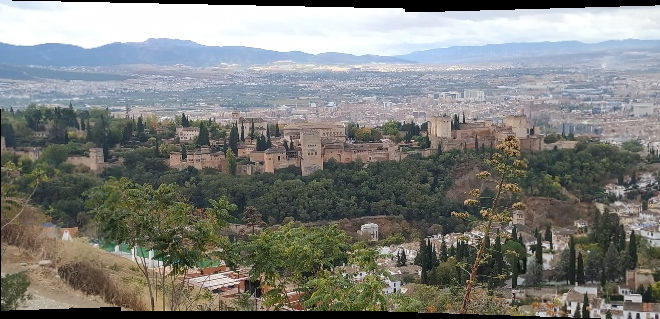

In [14]:
#Argumentos:
#   -img: Imagen 
#Retorna:
#   -imagen eliminando los bordes
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

#Argumentos:
#   -vim: Vector con las imagenes
#   -channels: Numero de canales de las imagenes
#Retorna:
#   -canvas: canvas lo suficientemente grande para almacenar el mosaico resultado
def canvasMosaico(vim,channels):
    height = max(img.shape[0] for img in vim)+1000
    width = sum(img.shape[1] for img in vim)

    #Create a new array with a size large enough to contain all the images
    canvas = np.zeros((height,width,channels),dtype=np.uint8)
    return canvas

#Argumentos:
#   -img1,img2: imágenes con correspondencias entre sí
#Retorna:
#   -matches: emparejamientos entre las imágenes
#   -keypoints1: keypoints SIFT detectados en img1
#   -keypoints2: keypoints SIFT detectados en img2
def calculateMatches(img1,img2):
  #Extraemos los keypoints
  sift = cv.SIFT_create()
  keypoints1, descriptor1 = sift.detectAndCompute(img1,None)  
  keypoints2, descriptor2 = sift.detectAndCompute(img2,None)   

  # Matching utilizando el criterio Lowe-Average-2NN
  bf = cv.BFMatcher(crossCheck=False)
  matches = bf.knnMatch(descriptor1, descriptor2, k=2)
  matches = [[m] for m,z in matches if m.distance < 0.7 * z.distance]

  return matches, keypoints1, keypoints2

#Argumentos:
#   -img1,img2: imágenes con correspondencias entre sí
#Retorna:
#   -H: Homografia entre img1 e img2
def estimateHomography(img1,img2):
  
  matches, keypoints1, keypoints2 = calculateMatches(img1,img2)
  
  # Extraemos los puntos asociados a los mejores matches
  points1 = np.zeros((len(matches), 2), dtype=np.float64)
  points2 = np.zeros((len(matches), 2), dtype=np.float64)
  
  for i, match in enumerate(matches):

    points1[i, :] = keypoints1[match[0].queryIdx].pt
    points2[i, :] = keypoints2[match[0].trainIdx].pt

  # Find homography
  H, mask = cv.findHomography(points1,points2,cv.RANSAC,3.0)
  
  return H
  
#Leemos las imagenes

img1 = cv.imread('images/IMG_20211030_110413_S.jpg',1)
img2 = cv.imread('images/IMG_20211030_110415_S.jpg',1)
img3 = cv.imread('images/IMG_20211030_110417_S.jpg',1)

#Creamos el canvas sobre el que hacer el mosaico
vim = [img1,img2,img3]
canvas = canvasMosaico(vim,3)
altura_canvas,ancho_canvas,canales_canvas = canvas.shape
altura_base,ancho_base,canales_base = img2.shape

#Homografia de traslacion
H0 = np.array([[1,0,ancho_canvas//2 - ancho_base//2],
               [0,1,altura_canvas//2 - altura_base//2],
               [0,0,1]],dtype =np.float64)

#Homografias entre imagenes
H1 = estimateHomography(img1,img2)
H2 = estimateHomography(img3,img2)

#Trasladamos las imágenes al canvas utilizando las homografías
cv.warpPerspective(img1,H0.dot(H1),(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)
cv.warpPerspective(img3,H0.dot(H2),(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)
cv.warpPerspective(img2,H0,(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)

cv2_imshow(crop(canvas))


En este ejercicio se pide construir un mosaico a partir de 3 imágenes que se solapan 2-a-2. Este proceso tiene varias partes diferenciadas: extracción de keyPoints y cálculo de correspondencias; estimación de las homografías; construcción del canvas y de la homografía de traslación; y montaje del mosaico.

**Extracción de KeyPoints y cálculo de correspondencias**

> Este proceso lo implementa la función *calculateMatches()*. En dicha función, se extraen los descriptores SIFT asociados a una pareja de imágenes y se calculan los emparejamientos utilizando el criterio de *Lowe-Average-2NN*, el cual se vió que es más efectivo en el ejercicio anterior.



**Estimación de Homografías**
> A partir de un conjunto de emparejamientos, se debe calcular la homografía que lleva los puntos de una imagen en su emparejamiento en la otra imagen.

> Para calcular dicha homografía se utiliza la función de OpenCV *findHomography()*, la cual, a partir de un conjunto puntos emparejados, devuelve la homografía calculada empleando uno de los métodos disponibles para calcularla. Para ello hace empleo de varios algoritmos a elección del usuario, y en este caso el elegido es RANSAC. Este método  devuelve el mayor grupo de puntos que son coherentes con el modelo que se estudia, que en este caso es una homografía.


> En la función anterior es posible ajustar varios parámetros, si bien el único que nos interesa es **ransacReprojThreshold**. Este parámetro permite ajustar la precisión RANSAC, indicando el número de píxeles que se puede desviar un emparejamiento de la que sería su posición "idónea". Por defecto, este parámetro toma un valor de 5, si bien, tras diversas pruebas, se comprobó que con 3 se generaban homografías correctas, tanto para este ejercicio como para el bonus 2, donde se utilizará de nuevo esta función.


**Construcción del canvas y homografía de traslación**

> En primer lugar, se debe definir la superficie sobre la cual se construirá el mosaico, el *canvas*. Esto se realiza en la función *canvasMosaico()*, la cual crea un espacio lo suficientemente grande para que quepa el mosaico una vez construído sin problemas.

> Tras esto, se debe definir la *homografía de traslación*. Esta homografía es la encargada de llevar las imágenes al mosaico. Para construirla, seleccionamos cual va a ser la imagen central del mosaico (en este caso tiene que ser la que esté en medio, ya que es la que tiene puntos en común con las otras dos), y la definimos en función del tamaño de esta imagen y del tamaño del canvas: $$ \begin{pmatrix} 1 & 0 & \frac{anchoCanvas}{2} – \frac{imagen.shape[1]}{2} \\ 0 & 1 & \frac{altoCanvas}{2} – \frac{imagen.shape[0]}{2} \\ 0 & 0 & 1 \end{pmatrix} $$

**Montaje del mosaico**


> Una vez se tienen todos los elementos, solo falta juntarlos para construir el mosaico. Utilizando las homografías calculadas previamente, se deben llevar las imágenes al canvas, utilizando para ello la función de OpenCV *warpPerspective()*. Para trasladar la imagen central, simplemente debemos aplicar la homografía de traslación $H0$. Sin embargo, para montar las otras imágenes, debemos aplicar dos homografías: la homografía entre las imagen y la imagen central, y la homografía que lleva la imagen central al canvas. Para aplicar varias homografías sobre una imagen, basta con multiplicarlas entre sí.

Juntando todos los pasos anteriores, se obtiene el mosaico que se muestra en este apartado, al cual se le han eliminado los bordes negros sobrantes debidos al tamaño inicial del canvas utilizando la función *crop()*.






  












#Bonus 1
**Implementar el refinamiento de localización de puntos extremos en el espacio de escalas Laplaciano. Aplicarlo a los puntos encontrados en el punto 1 y mostrar que la implementación realmente mejora la estimación inicial usando imágenes de los entornos de los puntos.**

In [15]:
#Argumentos:
#   -cubo: Cubo asociado al pixel a analizar
#   -i,j: coordenadas del pixel respecto de su escala dentro del cubo
#Retorna:
#   -offset: Refinamiento calculado para cada componente
#   -i_refinado,j_refinado: coordenadas refinadas
def refinamientoLaplaciano(cubo,i,j):
  #-------------------------Refinamiento Laplaciano----------------------------#
   #Calculo del gradiente/Jacobiano
   gradiente = np.array([(cubo[i,j,2]-cubo[i,j,0])/2,
                         (cubo[i+1,j,1]-cubo[i-1,j,1])/2,
                         (cubo[i,j+1,1]-cubo[i,j-1,1])/2
                        ],dtype=np.float64)
            
   #Calculo de la Hessiana
   h11 = cubo[i,j,2] + cubo[i,j,0] - 2*cubo[i,j,1]
   h22 = cubo[i+1,j,1] + cubo[i-1,j,1] - 2*cubo[i,j,1]
   h33 = cubo[i,j+1,1] + cubo[i,j-1,1] - 2*cubo[i,j,1]
   h12 = (cubo[i+1,j,2] - cubo[i-1,j,2] - cubo[i+1,j,0] + cubo[i-1,j,0])/4
   h13 = (cubo[i,j+1,2] - cubo[i,j-1,2] - cubo[i,j+1,0] + cubo[i,j-1,0])/4
   h23 = (cubo[i+1,j+1,1] - cubo[i+1,j-1,1] - cubo[i-1,j+1,1] + cubo[i-1,j-1,1])/4
            
   hessiana = np.array([[h11,h12,h13],
                        [h12,h22,h23],
                        [h13,h23,h33]],dtype=np.float64)
            
   #Calculo del offset
   offset = -1*np.linalg.inv(hessiana).dot(gradiente)

   #Comprobacion de si es necesario el refinamiento de las coordenadas del punto
   if np.absolute(offset[0])>0.5:
      i_refinado = i+np.ceil(offset[0]) if offset[0]>0 else i+np.floor(offset[0])
   else:
      i_refinado = i
   if np.absolute(offset[1])>0.5:
      j_refinado = j+np.ceil(offset[1]) if offset[1]>0 else j+np.floor(offset[1])
   else:
      j_refinado = j

   return offset,i_refinado,j_refinado

#Argumentos:
#   -scaleSpace: Espacio de escalas laplaciano
#   -nmax: Numero de maximos locales con mayor respuesta a devolver
#Retorna:
#   -extremos_refinados: Lista con los nmax pixeles (x,y,sigma)  con mayor respuesta con refinamiento
#   -extremos: Lista con los nmax pixeles (x,y,sigma)  con mayor respuesta 
#   -offsets: Listado de los offsets calculados para cada punto de cara al refinamiento
def localExtremesWithOffset(scaleSpace,nmax):
  #Ver "AnatomySIFT", pagina 6--------------------------------
  delta_o = lambda o: 2**(o-1)
  sigma_o_s = lambda s,o: delta_o(o)*1.6*2**(s/3)
  sigma_o_s_offset = lambda s,o,offset: delta_o(o)*1.6*2**((s+offset)/3) 
  #-----------------------------------------------------------
  noctaves = len(scaleSpace)
  nscales = len(scaleSpace[0])

  extremos_refinados = [] #Listado resultado refinados
  extremos = [] #Listado resultado sin refinar
  offsets = [] #Listado con los offsets de refinamiento

  valoresScaleSpace = []
  ubicaciones = []
  cubos = []
  indiceCubo = -1

  #Las escalas comparadas en cada octava son las 0-1-2 [0:3],1-2-3 [1:4] y 2-3-4 [2:5]
  for o in range(noctaves):#Seleccionamos una octava
    #En cada octava, analizamos 3 conjuntos de 3 escalas
    octava = scaleSpace[o][:]
    for s in range(0,3):
      cubo= octava[:,:,s:s+3]
      cubos.append(cubo)
      indiceCubo = indiceCubo + 1
      width, height, channels = cubo[:,:,:].shape
      #Recorremos cada conjunto, comparando un pixel de la capa central con sus 26 vecinos en esa capa y las externas
      for i in range(1,width-1): #Eliminamos la ultima fila y la ultima columna porque ahi no se puede comparar con 26 vecinos!
        for j in range(1,height-1):
          vector = np.copy(cubo[i-1:i+2,j-1:j+2,0:3]).flatten()   
          puntoCentral = vector[13]
          vector = np.subtract(vector,puntoCentral)    
          valoresScaleSpace.append(vector)
          ubicaciones.append([i,j,s,o,cubo[i,j,1],indiceCubo])
      
  #Convertimos los puntos en una matriz de 27 columnas
  listado = np.copy(valoresScaleSpace).flatten()
  listado = np.reshape(listado,(len(valoresScaleSpace),27))
 
 #Binarizamos la matriz y sumamos por filas
  binarizacion = np.where(listado>0,1,0)
  sumas = np.sum(binarizacion,axis=1)

  for i in range(sumas.shape[0]):
    if sumas[i]==26 or sumas[i]==0:
      iE = ubicaciones[i][0]
      jE = ubicaciones[i][1]
      sE = ubicaciones[i][2]
      oE = ubicaciones[i][3]
      valorE = np.absolute(ubicaciones[i][4])
      indiceCubo = ubicaciones[i][5]
      
      offset,i_refinado,j_refinado = refinamientoLaplaciano(cubos[indiceCubo],iE,jE)
      delta = delta_o(oE)
      extremos.append([np.ceil(delta*iE),np.ceil(delta*jE),sigma_o_s(sE,oE),valorE])
      extremos_refinados.append([np.ceil(delta*i_refinado),np.ceil(delta*j_refinado),sigma_o_s_offset(sE,oE,offset[2]),valorE])
      offsets.append([offset[0],offset[1],offset[2],valorE])

  #Una vez tenemos los listados, los ordenamos de la misma manera para poder compararlos uniformemente
  extremos_refinados = np.array(extremos_refinados)
  extremos_refinados = extremos_refinados[np.argsort(-extremos_refinados[:,3])[:nmax]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremos_refinados = np.delete(extremos_refinados,3,1) #Eliminamos la ultima componente de todos los puntos ("la ultima columna de la matriz")

  extremos = np.array(extremos)
  extremos = extremos[np.argsort(-extremos[:,3])[:nmax]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  extremos = np.delete(extremos,3,1) #Eliminamos la ultima componente de todos los puntos ("la ultima columna de la matriz")
  
  offsets = np.array(offsets)
  offsets = offsets[np.argsort(-offsets[:,3])[:nmax]] #Ordenamos en funcion del valor de los pixeles, y nos quedamos solo con lo nmax de mayor respuesta
  offsets = np.delete(offsets,3,1) #Eliminamos la ultima componente de todos los puntos ("la ultima columna de la matriz")
  
  return extremos_refinados,extremos,offsets


#Leemos la imagen
img = cv.imread('images/Yosemite1.jpg',0).astype(np.float64)
nscales=3
noctaves=4

#Obtenemos la imagen semilla
seed_img = seedImage(img)
#Calculamos la octavas
octaves = obtainOctaves(seed_img,nscales,noctaves)
#Calculamos el espacio de escalas laplaciano
scaleSpace = laplacianScaleSpace(octaves)
#Obtenemos los extremos locales (con y sin refinamiento)
extremos_refinados,extremos,offsets= localExtremesWithOffset(scaleSpace,100)

with np.printoptions(formatter={'float': '{: 0.4f}'.format}):
  print("\n-------Extremo original--------------Extremos refinados-------------Offset----------")
  for i in range(50):
    print(extremos[i],extremos_refinados[i],offsets[i])


-------Extremo original--------------Extremos refinados-------------Offset----------
[ 201.0000  29.0000  0.8000] [ 201.0000  29.0000  0.7674] [-0.3089  0.3550 -0.1799]
[ 218.0000  172.0000  0.8000] [ 218.0000  172.0000  0.7325] [ 0.1890 -0.2154 -0.3817]
[ 246.0000  69.0000  0.8000] [ 246.0000  71.0000  0.8878] [-0.6146  3.9730  0.4509]
[ 231.0000  187.0000  1.2699] [ 231.0000  187.0000  1.2039] [-0.1671 -0.0439 -0.2310]
[ 219.0000  176.0000  0.8000] [ 219.0000  176.0000  0.8910] [-0.4838  0.3516  0.4662]
[ 230.0000  179.0000  1.0079] [ 230.0000  179.0000  0.8914] [ 0.2417  0.0369 -0.5317]
[ 257.0000  80.0000  1.0079] [ 257.0000  80.0000  1.0206] [-0.0475  0.2556  0.0542]
[ 235.0000  63.0000  1.0079] [ 235.0000  63.0000  1.0234] [ 0.1332 -0.0401  0.0660]
[ 262.0000  30.0000  1.0079] [ 262.0000  30.0000  1.0702] [-0.1425 -0.1476  0.2593]
[ 115.0000  158.0000  0.8000] [ 115.0000  158.0000  0.7905] [-0.3644  0.0260 -0.0515]
[ 170.0000  210.0000  0.8000] [ 170.0000  210.0000  0.8056] [-0.

En este ejercicio se pide implementar el refinamiento de localización de puntos extremos en el espacio de escalas Laplaciano. Este refinamiento se aplica sobre los extremos seleccionados en el espacio de escalas, y consiste en ajustar de una manera más finas las coordenadas del keypoint $(x,y,\sigma)$. ¿Por qué es necesario este refinamiento?

La localización de los extremos está limitada por la rejilla que se define en cada octava. Sin embargo, puede que el verdadero extremo se encuentre ligeramente desplazado, y el algortimo SIFT define un proceso para desplazar hasta una localización más exacta dicho extremos utilizando una interpolación. Veamos brevemente en qué consiste este proceso.

Se $D(x,y,\sigma)$ la función que representa al espacio de escalas, un punto de este espacio se puede representar en función de esta función como $$D(x) = D + \frac{\partial D}{\partial x}^Tx + \frac{1}{2}x^T\frac{\partial^2 D}{\partial x^2}x$$

Derivando la expresión anterior e igualando a cero, podemos encontrar la localización del extremo $$\hat{x}=-\frac{\partial^2 D}{\partial x^2}^{-1} \frac{\partial D}{\partial x}$$
donde $\frac{\partial^2 D}{\partial x^2}$ es la matriz **Hessiana** y $\frac{\partial D}{\partial x}$ la matriz **Jacobiana** (o gradiente, en este caso)

La Hessiana y el Jacobiano son costosos de calcular en cada punto. Sin embargo, el propio paper de Lowe sugiere que es posible calcular los valores utilizando diferencias de puntos cercanos. Esto es lo que realiza la función *refinamientoLaplaciano()*: utilizando los puntos del cubo donde se encuentra el máximo, calcula el **offset** $\hat{x}$ que es necesario añadir a cada extremo para refinarlo. El hecho de que los cálculos dependan del cubo donde se encuentra el máximo obliga a modificar ligeramente el código desarrollado en el ejercicio 1, introduciendo una variables *cubos* para almacenar un listado de todos los cubos, y otra denominada *indiceCubos*, la cual se añade como otra componente al listado de *ubicaciones*, para vincular cada punto al cubo en el que se encuentra originalmente.

Los cálculos completos se realizan en el código para construir las variables *gradiente* y *hessiana*, y se pueden consultar en el paper *AnatomySIFT.pdf*. A modo de resumen, se basa en calcular la diferencia entre píxeles cercanos, tanto en la misma escala, como en la escala inmediatamente superior e inferior (las que forman parte del cubo), y en función de como se opere con estos valores, se hallan las diferentes componentes del gradiente y de la hessiana.

Ahora bien, Lowe impone que, para que este refinamiento sea tenido en cuenta, al menos debe modificar el valor original de cada componente del extremo en 0.5. De ahí que se compare si cada valor supera ese umbral, sumándole al valor el techo (o restándole el techo, si es negativo) a las coordenadas de los píxeles (la asociada al sigma no es necesaria redondearla).

Finalmente, se devuelven los valores de los extremos refinados y el refinamiento calculado, de cara a imprimirlo al final del proceso para comprobar cómo mejora la detección de los extremos respectos a la versión de SIFT sin este refinamiento (desarrollada en el ejercicio 1).

A modo de resultados se presenta un listado de los 50 mayores extremos, junto con su posición refinada y el offset aplicdco. Cabe mencionar que, si bien el enunciado del ejercicio pide mostrar imágenes, en clase de prácticas se comentó que no hiciésemos eso (ya que en las imágenes no se pueden observar las diferencias del refinamiento, muy sutiles en general).

Analizando el listado se puede ver como el refinamiento es, en general, muy pequeño, de variaciones de entre 1 y 3 píxeles en las coordenadas del extremo en la imagen original. Esto concuerda con la precisión del algoritmo SIFT y explica el porqué de que en el ejercicio 1 los resultados obtenidos fuesen coherentes, a pesar de haber omitido este paso.

#Bonus 2, opción 1
**Construir un panorama con proyección plana con todas las imágenes del fichero**

In [16]:
#Argumentos:
#   -imagenes: array de imagenes con correspondencias 2-a-2 entre imagenes consecutivas
#   -centroHomografia: Imagen que se elige como central del panorama
#Retorna:
#   -canvas: canvas con el panorama realizado en su interior
def panorama(imagenes,centroHomografia):

  centroHomografia = centroHomografia -1 # Los indices en los arrays empiezan en 0
  #Creamos el canvas
  canvas = canvasMosaico(imagenes,3)
  altura_canvas,ancho_canvas,canales_canvas = canvas.shape
  altura_base,ancho_base,canales_base = imagenes[centroHomografia].shape 

  #Homografia de traslacion al canvas
  H0 = np.array([[1,0,ancho_canvas//2 - ancho_base//2],
               [0,1,altura_canvas//2 - altura_base//2],
               [0,0,1]],dtype =np.float64)

  left_homographies = []
  right_homographies = []

  #Homografias entre imágenes
  numImgs = len(imagenes)

  for i in range(centroHomografia): 
    left_homographies.append(estimateHomography(imagenes[i],imagenes[i+1]))

  for i in range(numImgs-1,centroHomografia,-1): 
    right_homographies.append(estimateHomography(imagenes[i],imagenes[i-1]))

  numLeftHom = len(left_homographies)
  numRightHom = len(right_homographies)

  #Colocamos las imagenes en el canvas
  for i in range(numLeftHom): 
    M = left_homographies[i]
    for j in range(i+1,numLeftHom):
      M = left_homographies[j].dot(M)
    M = H0.dot(M)
    cv.warpPerspective(imagenes[i],M,(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)

  for i in range(numRightHom): 
    M = right_homographies[i]
    for j in range(i+1,numRightHom):
      M = right_homographies[j].dot(M)
    M = H0.dot(M)
    cv.warpPerspective(imagenes[numImgs-i-1],M,(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)

  cv.warpPerspective(imagenes[centroHomografia],H0,(ancho_canvas,altura_canvas),dst = canvas, borderMode = cv.BORDER_TRANSPARENT)
  canvas = crop(canvas)

  return canvas

#Leemos las imagenes
img1 = cv.imread('images/IMG_20211030_110410_S.jpg',1)
img2 = cv.imread('images/IMG_20211030_110413_S.jpg',1)
img3 = cv.imread('images/IMG_20211030_110415_S.jpg',1)
img4 = cv.imread('images/IMG_20211030_110417_S.jpg',1)
img5 = cv.imread('images/IMG_20211030_110418_S.jpg',1)
img6 = cv.imread('images/IMG_20211030_110420_S.jpg',1)
img7 = cv.imread('images/IMG_20211030_110421_S.jpg',1)
img8 = cv.imread('images/IMG_20211030_110425_S.jpg',1)
img9 = cv.imread('images/IMG_20211030_110426_S.jpg',1)
img10 = cv.imread('images/IMG_20211030_110428_S.jpg',1)
img11 = cv.imread('images/IMG_20211030_110431_S.jpg',1)
img12 = cv.imread('images/IMG_20211030_110433_S.jpg',1)
img13 = cv.imread('images/IMG_20211030_110434_S.jpg',1)
img14 = cv.imread('images/IMG_20211030_110436_S.jpg',1)

#Creamos el canvas sobre el que hacer el mosaico
imagenes = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12,img13,img14]

mosaico7 = panorama(imagenes,centroHomografia = 7)
mosaico5 = panorama(imagenes,centroHomografia = 5)

print("\nMosaico con el centro en la imagen 7")
cv2_imshow(mosaico7)
print("Mosaico con el centro en la imagen 5")
cv2_imshow(mosaico5)


Output hidden; open in https://colab.research.google.com to view.

Este ejercicio es una amplicación del ejercicio 3. En lugar de hacer un panorama con 3 imágenes, debemos hacerlo con un conjunto mayor de imágenes (14 en este caso), para generar un panorama completo de la Alhambra y la ciudad de Granada.

El proceso es similar al explicado anteriormente, salvo en dos partes: el cálculo de la homografía que lleva cada imagen al canvas, y la elección de la imagen central.

**Cálculo de las homografías**


> El cálculo de las homografías entre dos imágenes se realiza de la misma manera que en el ejercicio 3, aunque esta vez, para mayor comodidad en la programación, se almacenan en dos vectores:
*   El array **left_homographies[ ]** almacena las homografías de las imágenes que están a la izquierda de la imagen central.
*   El array **right_homographies[ ]** almacena las homografías de las imágenes que están a la derecha de la imagen central.
La razón de esta  separación es que las homografías por la izquierda se calculan de la imagen 1 a la 2, de la 2 a la 3, etc, mientras que por la derecha se deben calcular a la inversa: de la 14 a la 13, de la 13 a la 12... (o calcularlas de la misma manera y luego invertir las matrices de homografía).



> Donde existe una diferencia mayor es en la traslación de una imagen al canvas. La homografía de traslación $H0$ es la misma que en el ejercicio 3, pero para trasladar el resto de imágenes al canvas, en lugar de multiplicar solamente la matriz de homografía por $H0$, debemos multiplicarla por todas las matrices de homografías intermedias. Por ejemplo, si la imagen central es la imagen 4, y queremos colocar en el canvas la imagen 1, debemos multiplicar, en este orden, $$H0 \times Homografia[3,4] \times Homografia[2,3] \times Homografia[1,2]$$
siendo $Homografia[i,j]$ la homografía entre la imagen $i$ y la imagen $j$.

**Elección de la imagen central**


> En el ejercicio 3, la elección de la imagen central, al ser solamente 3 imágenes con solapamiento 2-a-2, era obvia. En este caso, la primera idea sería elegir la mitad del vector de imágenes (el 7) como centro del panorama. Sin embargo, debido a como están tomadas las fotografías con las que se trabaja (las primeras están sacadas a objetos mucho más cercanos), si se elige esta imagen, el panorama queda muy distorsionado en el lado izquierdo, como se puede ver en el primer panorama de ejemplo. Tras probar varias opciones, se vio que tomando como imagen central la 5, las distorsiones laterales, si bien existen, disminuyen enormemente (se puede apreciar especialmente en el extremo derecho, pero en un grado mucho menor a las que muestra el caso centrado en 7 en el extremo izquierdo).

En los panoramas obtenidos como resultados, se puede ver el hecho de que las homografías sean correctas especialemente en las montañas que se ven de fondo a lo largo de la imagen. Si bien cada imagen parcial contiene un fragmento de la sierra, el panorama final muestra la sierra como si hubiese sido sacada en una sola toma. Ahora bien, dónde más se nota que en realidad son varias imágenes es, además de en los bordes irregulares superiores e inferiores (las imágenes originales tenían diferentes tamaños), es en el hecho de que esta versión no implementan *blending* de colores; esto es, ajustar los colores en las zonas de intersección de las imágenes para que los cambios de una imagen a otra sean lo más suaves posibles.







#Bibliografía



*   https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

*   https://www.kite.com/python/answers/how-to-sort-the-rows-of-a-numpy-array-by-a-column-in-python

*    https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order/16486305

*    https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

*    https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv 

*     https://stackoverflow.com/questions/2891790/how-to-pretty-print-a-numpy-array-without-scientific-notation-and-with-given-pre

*     Papers de Prado asociados a los temas 3 y 4.

*     Apuntes de la asignatura de los temas 3 y 4.


 


